# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

survey = survey.loc[:,survey_fields]
data["survey"] = survey

c:\users\davi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")



In [11]:
survey_fields = [
    "rr_s",
    "N_s", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "rr_t",
    "N_t", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "rr_p",
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11",
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

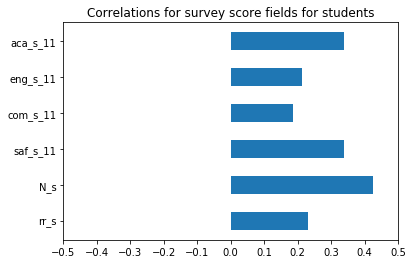

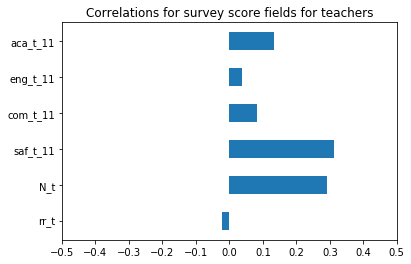

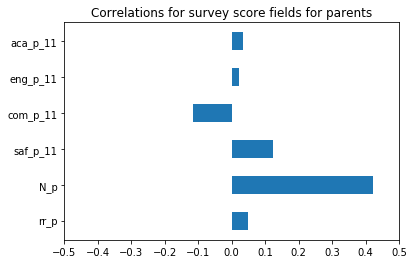

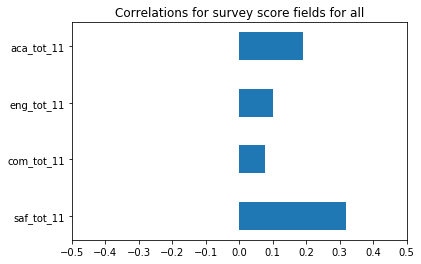

In [12]:
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline

plt.close()

xt = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
surv_fields = survey_fields
surv_titles = ["for students", "for teachers", "for parents", "for all"]
for i in range(0,4):
    s_fields = surv_fields[6*i:(6*i+6)]
    bar_positions = arange(len(s_fields)) + 1
    bar_widths = correlations[s_fields]
    tick_positions = range(1,len(s_fields)+1)

    fig, ax = plt.subplots()
    ax.barh(bar_positions, bar_widths, 0.5)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(s_fields)
    ax.set_title("Correlations for survey score fields " + surv_titles[i])
    ax.set_xlim(-0.5,0.5)
    ax.set_xticks(xt)
    plt.show()

The strongest correlations are N_t, N_s, N_p, saf_s_11, saf_t_11, saf_tot_11 and aca_s_11
Actually N_t, N_s and N_p makes little sense to be correlated, why would number of respondents for a survey in a school correlate to SAT scores? The only reason I  can think of is that only the best schools, which have the most interested students and parents, cared to take the survey. 

The safety and respect score are correlated when related to students and teachers, but not when parents are related. It must be probably because a safe school is not measured by what parents think (status), but by what people who are there everyday, like students and teachers, think. But it is clear that a safe and respectful school brings good results.

When it comes to academic expectations, only students are correct. Parents probably have no idea about the academic quality of a school, since its r correlation is close to zero, which also probably means that they don't participate much in their children's school life. When it comes to teachers, their own ego probably deviates their correlation (they tend to think of themselves better than reality is), while students are the ones who have a real idea of what is really going on.

The engagement and commucation r correlation scores are really low, which means they don't have much influence in SAT scores at all, even though it is significant that there also students know better than teachers and parents.

When it comes to all, safety and respect is what brings the best SAT results, even more than academic expectations.

[]

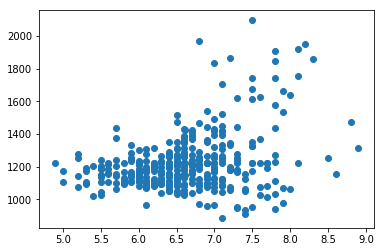

In [13]:
fig, ax = plt.subplots()
ax.scatter(combined["saf_s_11"],combined["sat_score"])
plt.plot()

It is true that all the best school have safety scores of at least 6.5, which is above average, but not all schools who have good safety scores have good SAT scores.

In [14]:
district_list = combined["school_dist"].unique()
district_list

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype=object)

In [15]:
dist_saf_scores = {}
max_dist_saf_score = 0
min_dist_saf_score = 3000
for d in district_list:
    dist_saf_score = combined[combined["school_dist"]==d]["saf_tot_11"].mean()
    if max_dist_saf_score < dist_saf_score:
        max_dist_saf_score = dist_saf_score
    if min_dist_saf_score > dist_saf_score:
        min_dist_saf_score = dist_saf_score
for d in district_list:
    dist_saf_score = combined[combined["school_dist"]==d]["saf_tot_11"].mean()
    dist_saf_scores[d] = ((dist_saf_score-min_dist_saf_score)/(max_dist_saf_score-min_dist_saf_score))
dist_saf_scores

{'01': 0.7267759562841526,
 '02': 0.7841530054644807,
 '03': 0.5956284153005463,
 '04': 0.9110070257611244,
 '05': 0.49882903981264537,
 '06': 0.8754098360655734,
 '07': 0.6998738965952083,
 '08': 0.5856929955290613,
 '09': 0.6819672131147542,
 '10': 0.6184798807749616,
 '11': 0.4994535519125671,
 '12': 0.8797814207650276,
 '13': 0.6191677175283731,
 '14': 0.7283372365339574,
 '15': 0.39890710382513644,
 '16': 0.0,
 '17': 0.4004683840749413,
 '18': 0.5141579731743665,
 '19': 0.28415300546448014,
 '20': 0.8491803278688527,
 '21': 0.5022354694485839,
 '22': 1.0,
 '23': 0.48633879781420725,
 '24': 0.9369482976040355,
 '25': 0.7868852459016397,
 '26': 0.5344262295081957,
 '27': 0.44918032786885265,
 '28': 0.7466467958271232,
 '29': 0.4180327868852458,
 '30': 0.8214936247723138,
 '31': 0.5737704918032787,
 '32': 0.6939890710382516}

In [16]:
max_dist_saf_score

7.85

In [17]:
min_dist_saf_score

6.325000000000001

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  CSD       ...        \
0                         

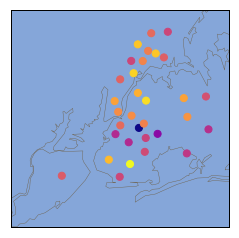

In [18]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

districts = combined.groupby("school_dist").mean()
districts.reset_index(inplace=True)
districts["norm_saf_score"]=list(dist_saf_scores.values())
print(districts.head())

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(x=longitudes, y=latitudes, s=50, zorder=2, latlon=True, c=districts["norm_saf_score"], cmap="plasma")
plt.show()

There are small islands of high safety scores in the greater regions of New York.

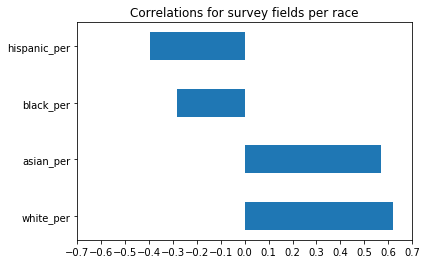

In [19]:
plt.close()

survey_fields = ["white_per","asian_per","black_per","hispanic_per"]
xt = [-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
s_fields = survey_fields
bar_positions = arange(len(s_fields)) + 1
bar_widths = correlations[s_fields]
tick_positions = range(1,len(s_fields)+1)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(s_fields)
ax.set_title("Correlations for survey fields per race")
ax.set_xlim(-0.7,0.7)
ax.set_xticks(xt)
plt.show()

As expected, white and asian are highly correlated with sat_scores in a positive way, while black and hispanic are correlated in a negative way. Without knowing the SAT test, I wouldn't say it is unfair in its questions, it is more likely that the educational system itself is racist, specially if the schools are themselves divided by race.

[]

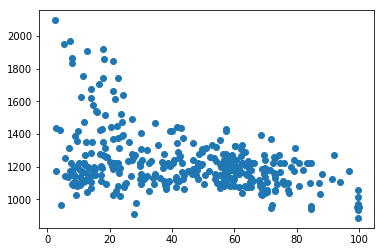

In [20]:
fig, ax = plt.subplots()
ax.scatter(combined["hispanic_per"],combined["sat_score"])
plt.plot()

No schools with more than 1500 SAT score has more than 20% of hispanic people. All-hispanic schools behave really bad in SAT tests.

In [21]:
print(combined[combined["hispanic_per"]>95])

        DBN                                        SCHOOL NAME  \
44   02M542                      MANHATTAN BRIDGES HIGH SCHOOL   
82   06M348   WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL   
89   06M552  GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...   
125  09X365                ACADEMY FOR LANGUAGE AND TECHNOLOGY   
141  10X342              INTERNATIONAL SCHOOL FOR LIBERAL ARTS   
176  12X388   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE   
253  19K583                          MULTICULTURAL HIGH SCHOOL   
286  24Q296             PAN AMERICAN INTERNATIONAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
44                      66                            336.0   
82                      70                            380.0   
89                      56                            339.0   
125                     54                            315.0   
141                     49                            300.0   
176                     30 

In [22]:
best_schools = combined[combined["hispanic_per"]<10]
best_schools = best_schools[best_schools["sat_score"]>1800]
print(best_schools)

        DBN                                        SCHOOL NAME  \
37   02M475                             STUYVESANT HIGH SCHOOL   
151  10X445                       BRONX HIGH SCHOOL OF SCIENCE   
187  13K430                     BROOKLYN TECHNICAL HIGH SCHOOL   
327  28Q687  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...   
356  31R605                STATEN ISLAND TECHNICAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
37                     832                            679.0   
151                    731                            632.0   
187                   1277                            587.0   
327                    121                            612.0   
356                    227                            635.0   

     SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
37                 735.0                   682.0     2096.0   
151                688.0                   649.0     1969.0   
187                659.0           

Most schools with high hispanic rates are dedicated to racial inclusion schools, while all the best schools are specialized schools operated by the New York City Department of Education.

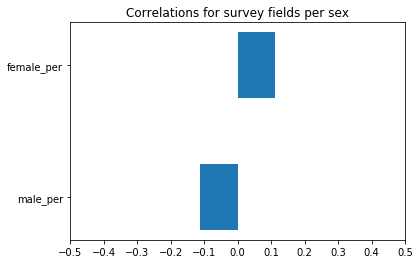

In [23]:
plt.close()

survey_fields = ["male_per","female_per"]
xt = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
s_fields = survey_fields
bar_positions = arange(len(s_fields)) + 1
bar_widths = correlations[s_fields]
tick_positions = range(1,len(s_fields)+1)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(s_fields)
ax.set_title("Correlations for survey fields per sex")
ax.set_xlim(-0.5,0.5)
ax.set_xticks(xt)
plt.show()

Slightly better for females than males, nothing very meaningful.

[]

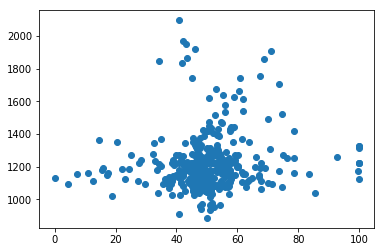

In [24]:
fig, ax = plt.subplots()
ax.scatter(combined["female_per"],combined["sat_score"])
plt.plot()

Top 4 schools have around 40% of females, while some few really good schools have more than 70% of women.

In [25]:
female_schools = combined[combined["female_per"]>60]
female_schools = female_schools[female_schools["sat_score"]>1700]
print(female_schools.loc[:,["school_name","sat_score","female_per"]])

                                           school_name  sat_score  female_per
5                       Bard High School Early College     1856.0        68.7
26                       Eleanor Roosevelt High School     1758.0        67.5
60                                  Beacon High School     1744.0        61.0
61   Fiorello H. LaGuardia High School of Music & A...     1707.0        73.6
302                        Townsend Harris High School     1910.0        71.1


These schools are mostly arts/humanities schools, and their number of students are quite small too.

[]

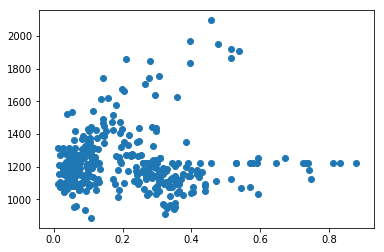

In [28]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]

fig, ax = plt.subplots()
ax.scatter(combined["ap_per"],combined["sat_score"])
plt.plot()

ap_per is fairly correlated with sat_score, since every really good school has at least 40% of its students taking AP tests, while very few of the schools below SAT score of 1200 has more than 40% of its students taking it. It also seems to have a line around 1225 SAT score, which may be a line created from data cleaning of absent SAT scores on the original database.

[]

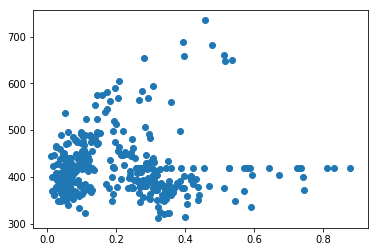

In [29]:
fig, ax = plt.subplots()
ax.scatter(combined["ap_per"],combined["SAT Math Avg. Score"])
plt.plot()

[]

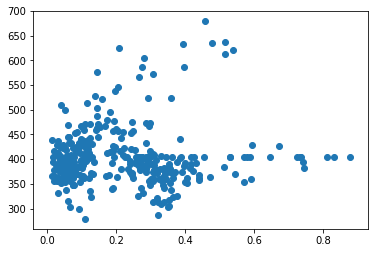

In [30]:
fig, ax = plt.subplots()
ax.scatter(combined["ap_per"],combined["SAT Critical Reading Avg. Score"])
plt.plot()

[]

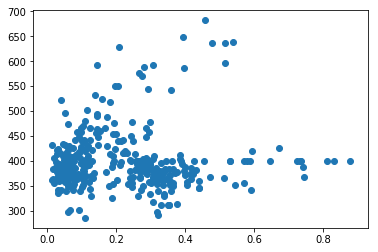

In [31]:
fig, ax = plt.subplots()
ax.scatter(combined["ap_per"],combined["SAT Writing Avg. Score"])
plt.plot()

[]

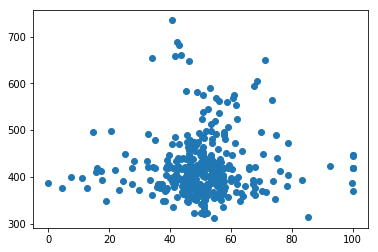

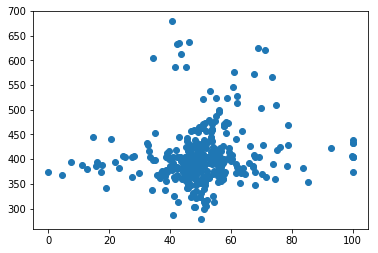

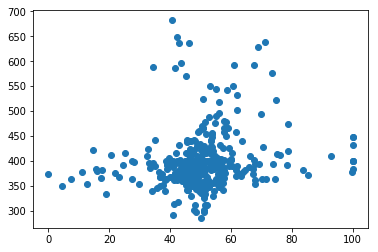

In [34]:
fig, ax = plt.subplots()
ax.scatter(combined["female_per"],combined["SAT Math Avg. Score"])
fig, ax = plt.subplots()
ax.scatter(combined["female_per"],combined["SAT Critical Reading Avg. Score"])
fig, ax = plt.subplots()
ax.scatter(combined["female_per"],combined["SAT Writing Avg. Score"])
plt.plot()

The AP test takers percentage per subject didn't shoow me much, but the female takers percentage per subject seems to show a stronger correlation to